In [1]:
import simpy
import numpy as np
import sys
from scipy import interpolate
from IPython.core.debugger import set_trace
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

sys.path.append('../..')

In [3]:
from physiolopy.organ.organ import OrganBase2, OrganInfo, Node
from physiolopy.chemical.chemical import Compartment3, GridCompartment, Reaction3, TestTube
from physiolopy.chemical.reaction import Respiration
from physiolopy.cell import PetriDish,Bacterium,OrganismFeatures,Movement,Action

In [32]:
def movimiento(action,state):
    
    h = action.getPeriodo() # segs
    time=state['time'] # Momento t-1
         
    organism = action.getOrganism()
    features = organism.getFeatures()
    x,y = features.getPosition(time)
        
    petri = organism.system
    size = petri.getSize()
        
    glucose = petri.getCompartment(x,y).state['D-Glucose']
        
    from math import sqrt
    hraiz = sqrt(h)
        
    intensidad = 0 if glucose <0.5 else 1
        
    random = action.getRandom()
    if intensidad == 1:
        dx= random.normalvariate(0,hraiz)*0.4
        dy= random.normalvariate(0,hraiz)*0.4
    else:
        dx = -x / abs(x) * 0.01 + random.normalvariate(0,hraiz)*0.4
        dy = -y / abs(y) * 0.01 + random.normalvariate(0,hraiz)*0.4

    x1 = x + dx
    y1 = y + dy
        
    x1 = size if x1>size else x1
    x1 = -size if x1<-size else x1
    y1 = size if y1>size else y1
    y1 = -size if y1<-size else y1
                       
    #features.setPosition((x1,y1))
    now = action.getTimeNow()
    state = features.getState(now)
    state['position'] = (x1,y1)        

In [33]:
bacts = []
num = 4
semillas = [271,532,8341,7182]

from random import Random
rnd = Random(932321)

from random import Random
for i in range(num):
    per = 0.001
    x0 = rnd.uniform(-1,1)
    y0 = rnd.uniform(-1,1)
    features=OrganismFeatures(position=(x0,y0),age=22,periodo=per)

    species={'D-Glucose':1,
                 'O2':1,
                 'CO2':0,
                 'H2O':0,
                 'ATP':0,
                 'glycogen':0}
    cp=Compartment3(species, periodo = per)

    bact=Bacterium(features=features,compartment=cp)

    bact.addReaction('Respiracion',Reaction3(['D-Glucose','O2','H2O','CO2','ATP'],
                [-1,-6,6,6,38],[1,1,0,0,1],kr=1,kl=1, periodo = per))

    bact.addAction('movimiento',Action(movimiento, seed=semillas[i], periodo = per))
    bacts.append(bact)

<IPython.core.display.Javascript object>


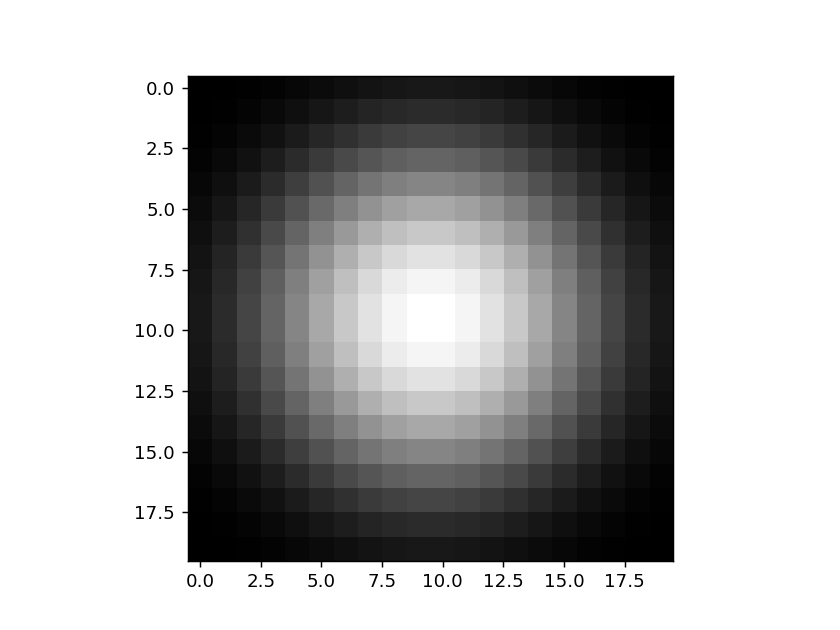

In [34]:
per = 0.001
species={'D-Glucose':1}
gcp=GridCompartment(species, bins = 20, periodo = per)

def fcp(x,y):
    from math import sin,pi
    z = (2-(x**2 + y**2)) /2
    #z1 = 0 if z<0.991 else 1
    z1 = z**4
    #z1 = sin(pi/2*z)
    return z1

gcp.setConcentration('D-Glucose',fcp)
gcp.showConcentration('D-Glucose')

In [35]:
petri = PetriDish(gcp)
for i in range(len(bacts)):
    petri.addCell(i,bacts[i])

In [36]:
env = simpy.Environment()
petri.connect(env)

env.run(until=1)

<IPython.core.display.Javascript object>


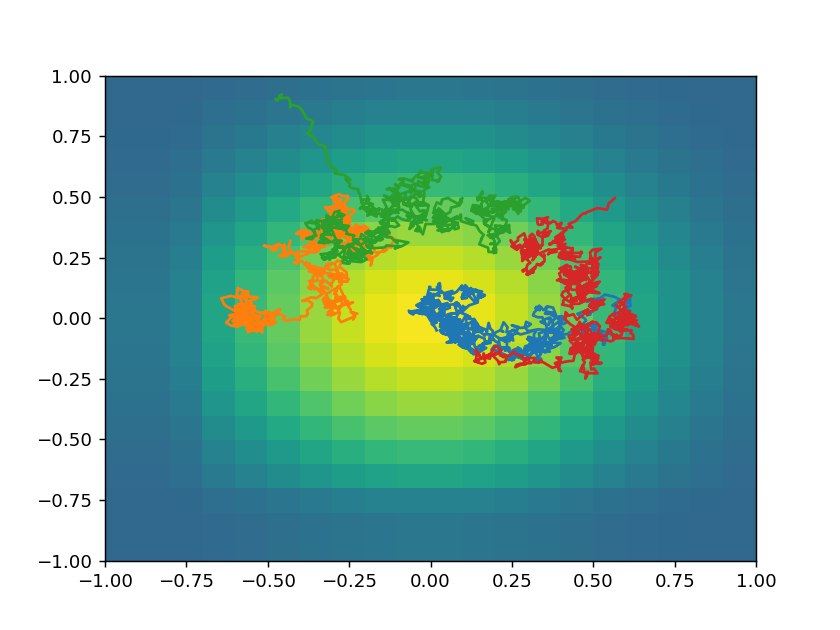

In [37]:
num = gcp.getBins() + 1 
size = petri.getSize()
xl = np.linspace(-size,size,num)
yl = np.linspace(-size,size,num)
X,Y = np.meshgrid(xl,yl)
Z = np.zeros(shape=(num, num))
for (i,j) in product(range(num),range(num)):
    cp = petri.getCompartment(xl[i],yl[j])
    Z[i,j]=cp.state['D-Glucose']

fig, ax = plt.subplots()
ax.pcolormesh(X,Y,Z,vmin=-0.5, vmax = 1.0)

plt.rcParams['figure.dpi'] = 100

size = petri.getSize()
plt.xlim(-size,size)
plt.ylim(-size,size)

cells = petri.getCells()
for c in cells:
    b=cells[c]
    f=b.getFeatures()
    df=f.getDataFrame()
    
    xx=[x for (x,y) in df['position']]
    yy=[y for (x,y) in df['position']]
        
    plt.plot(xx,yy)
    
plt.show()
    

<IPython.core.display.Javascript object>


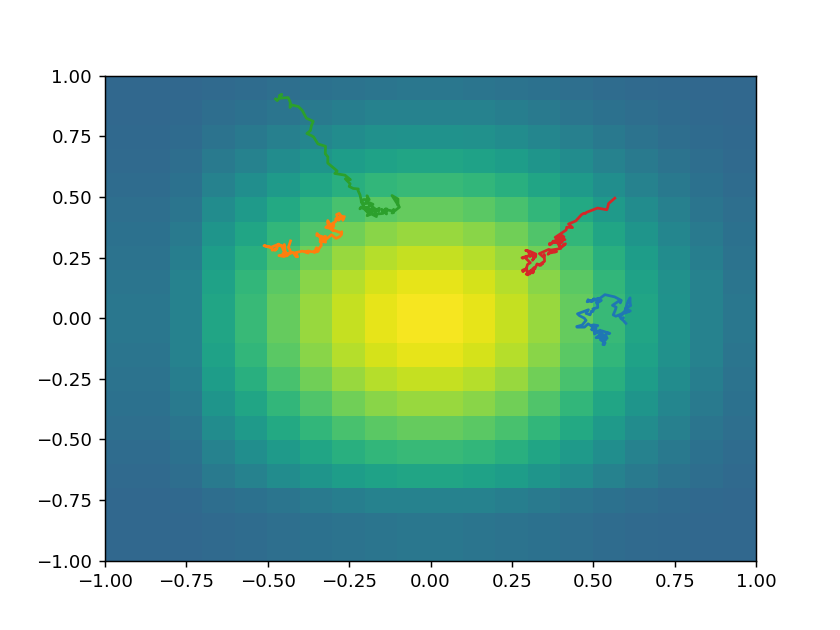

In [38]:
# Enable interactive plot
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

num_frames = len(petri.getCell(0).getFeatures().getDataFrame())

num = gcp.getBins() + 1 
xl = np.linspace(-size,size,num)
yl = np.linspace(-size,size,num)
X,Y = np.meshgrid(xl,yl)
Z = np.zeros(shape=(num, num))
for (i,j) in product(range(num),range(num)):
    cp = petri.getCompartment(xl[i],yl[j])
    Z[i,j]=cp.state['D-Glucose']

fig, ax = plt.subplots()
ax.pcolormesh(X,Y,Z,vmin=-0.5, vmax = 1.0)

lines = []
for c in cells:
    line, = ax.plot([]) # A tuple unpacking to unpack the only plot
    lines.append(line)

size = petri.getSize()
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)

def animate(frame_num):
    
    pos=0
    for c in cells:
        b=cells[c]
        f=b.getFeatures()
        df=f.getDataFrame()
                
        xx=[x for (x,y) in df['position']]
        yy=[y for (x,y) in df['position']]
        
        line = lines[pos]
        line.set_data((xx[0:frame_num], yy[0:frame_num]))
        pos += 1
            
    return lines
    

anim = FuncAnimation(fig, animate, frames=num_frames, interval=100)

<IPython.core.display.Javascript object>


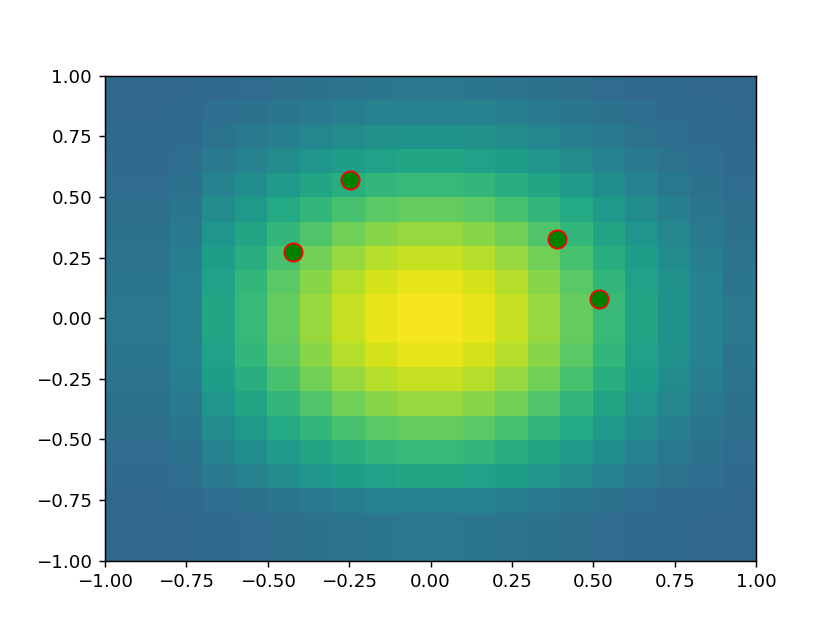

In [39]:
# Enable interactive plot
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

num_frames = len(petri.getCell(0).getFeatures().getDataFrame())

num = gcp.getBins() + 1 
xl = np.linspace(-size,size,num)
yl = np.linspace(-size,size,num)
X,Y = np.meshgrid(xl,yl)
Z = np.zeros(shape=(num, num))
for (i,j) in product(range(num),range(num)):
    cp = petri.getCompartment(xl[i],yl[j])
    Z[i,j]=cp.state['D-Glucose']

fig, ax = plt.subplots()
ax.pcolormesh(X,Y,Z,vmin=-0.5, vmax = 1.0)

lines = []
for c in cells:
    line, = ax.plot([], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green") # A tuple unpacking to unpack the only plot
    #plt.plot(x, y, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
    lines.append(line)

size = petri.getSize()
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)

def animate(frame_num):
    
    pos=0
    for c in cells:
        b=cells[c]
        f=b.getFeatures()
        df=f.getDataFrame()
                
        xx=[x for (x,y) in df['position']]
        yy=[y for (x,y) in df['position']]
        
        line = lines[pos]
        line.set_data((xx[frame_num-1], yy[frame_num-1]))
        
        pos += 1
            
    return lines
    

anim = FuncAnimation(fig, animate, frames=num_frames, interval=100)

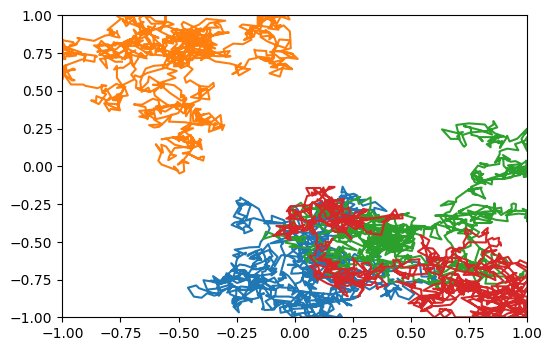

In [20]:
plt.rcParams['figure.dpi'] = 100

size = petri.getSize()
plt.xlim(-size,size)
plt.ylim(-size,size)

cells = petri.getCells()
for c in cells:
    b=cells[c]
    f=b.getFeatures()
    df=f.getDataFrame()
    
    xx=[x for (x,y) in df['position']]
    yy=[y for (x,y) in df['position']]
    
    #print(min(xx),max(xx),min(yy),max(yy))
    plt.plot(xx,yy)
    
plt.show()
    

<IPython.core.display.Javascript object>


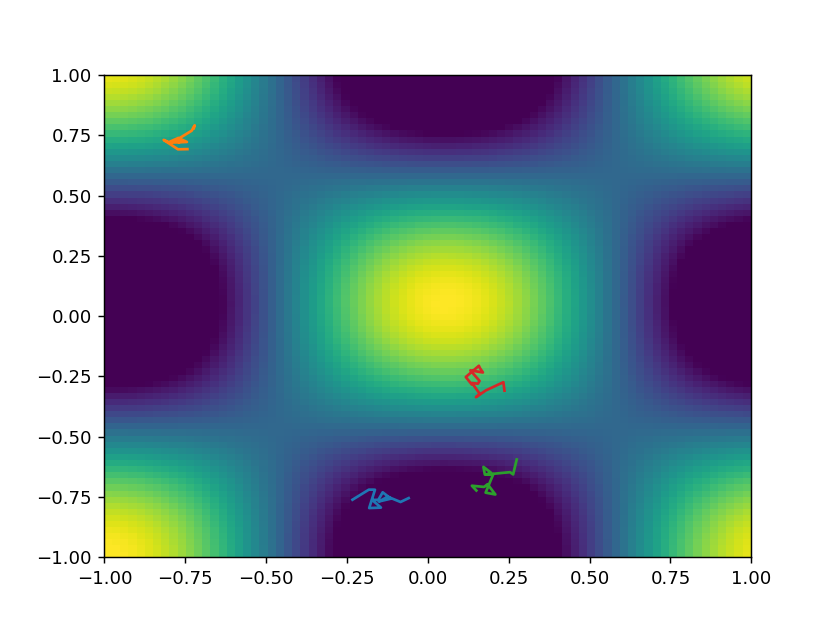

In [12]:
# Enable interactive plot
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

num_frames = len(petri.getCell(0).getFeatures().getDataFrame())

fig, ax = plt.subplots()

lines = []
for c in cells:
    line, = ax.plot([]) # A tuple unpacking to unpack the only plot
    lines.append(line)

size = petri.getSize()
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)

num = 80
xl = np.linspace(-size,size,num)
yl = np.linspace(-size,size,num)
X,Y = np.meshgrid(xl,yl)

Z = np.cos(6*(X-np.min(X))/(np.max(X)-np.min(X))) * np.cos(6*(Y-np.min(Y))/(np.max(Y)-np.min(Y)))

#ax.contour(X,Y,Z,vmin=-0.5, vmax = 1.0)
ax.pcolormesh(X,Y,Z,vmin=-0.5, vmax = 1.0)


def animate(frame_num):
    
    pos=0
    for c in cells:
        b=cells[c]
        f=b.getFeatures()
        df=f.getDataFrame()
                
        xx=[x for (x,y) in df['position']]
        yy=[y for (x,y) in df['position']]
        
        line = lines[pos]
        line.set_data((xx[0:frame_num], yy[0:frame_num]))
        pos += 1
            
    return lines

anim = FuncAnimation(fig, animate, frames=num_frames, interval=100)